In [3]:
!pip install requests
!pip install Pillow
!pip install matplotlib
!pip install numpy
!pip install --upgrade tensorflow
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Neccessary Libraries and packages

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from sklearn.model_selection import train_test_split

### Loading and Organizing Dataset

In [6]:
import requests
import zipfile
import io

# Define the URL of the dataset zip file
dataset_url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxsnvwty3r-1.zip"

# Define the destination directory where you want to save and extract the dataset
destination_dir = "/content/MangoLeafBD_Dataset"

# Create the destination directory if it doesn't exist
!mkdir -p {destination_dir}

# Download the dataset zip file
response = requests.get(dataset_url)
dataset_zip = zipfile.ZipFile(io.BytesIO(response.content))

# Extract the dataset to the destination directory
dataset_zip.extractall(destination_dir)

# Close the zip file
dataset_zip.close()

print("Dataset downloaded and extracted successfully.")

Dataset downloaded and extracted successfully.


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the root dataset directory
root_dir = "/content/MangoLeafBD_Dataset/MangoLeafBD Dataset"

# Define the target train and validation directories
train_dir = "/content/MangoLeafBD_Train"
val_dir = "/content/MangoLeafBD_Val"

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Define the class names
class_names = [
    "Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
    "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"
]

# Define the train-validation split ratio (adjust as needed)
val_split = 0.2

# Iterate through class names and move images to train and validation folders
for class_name in class_names:
    class_dir = os.path.join(root_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    # Create class directories in train and validation folders
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # List all images in the class directory
    images = os.listdir(class_dir)

    # Split images into train and validation sets
    train_images, val_images = train_test_split(images, test_size=val_split, random_state=42)

    # Move images to train and validation folders
    for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_class_dir, image)
        shutil.move(src, dst)

    for image in val_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(val_class_dir, image)
        shutil.move(src, dst)

print("Dataset organized into train and validation folders.")

Dataset organized into train and validation folders.


### Augmenting the data

In [8]:
# Define image preprocessing parameters
batch_size = 32
image_size = (224, 224)

# Create data generators with data augmentation for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


### Building the Convolutional neural network model

In [9]:
model = Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output and add fully connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')  # 8 classes for your dataset
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the Model

In [10]:
# Define the number of epochs
epochs = 20

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/20
100/100 [==============================] - 51s 435ms/step - loss: 1.7452 - accuracy: 0.2734 - val_loss: 1.4177 - val_accuracy: 0.4412
Epoch 2/20
100/100 [==============================] - 44s 436ms/step - loss: 1.0938 - accuracy: 0.5978 - val_loss: 0.7625 - val_accuracy: 0.7050
Epoch 3/20
100/100 [==============================] - 43s 434ms/step - loss: 0.7984 - accuracy: 0.7084 - val_loss: 0.4382 - val_accuracy: 0.8512
Epoch 4/20
100/100 [==============================] - 44s 437ms/step - loss: 0.5439 - accuracy: 0.8059 - val_loss: 0.5508 - val_accuracy: 0.7912
Epoch 5/20
100/100 [==============================] - 44s 440ms/step - loss: 0.4529 - accuracy: 0.8328 - val_loss: 0.3880 - val_accuracy: 0.8737
Epoch 6/20
100/100 [==============================] - 43s 434ms/step - loss: 0.3841 - accuracy: 0.8616 - val_loss: 0.2684 - val_accuracy: 0.8988
Epoch 7/20
100/100 [==============================] - 43s 433ms/step - loss: 0.3418 - accuracy: 0.8825 - val_loss: 0.5179 - val_ac

### Evaluation Metrics and Visualizations of training

25/25 [==============================] - 2s 65ms/step - loss: 0.0956 - accuracy: 0.9750
Metrics for Training Set:
Loss: 0.08368924260139465
Accuracy: 0.9753124713897705

Metrics for Validation Set:
Loss: 0.09555957466363907
Accuracy: 0.9750000238418579

Tabular Form of Metrics:
      Dataset      Loss  Accuracy
0    Training  0.083689  0.975312
1  Validation  0.095560  0.975000


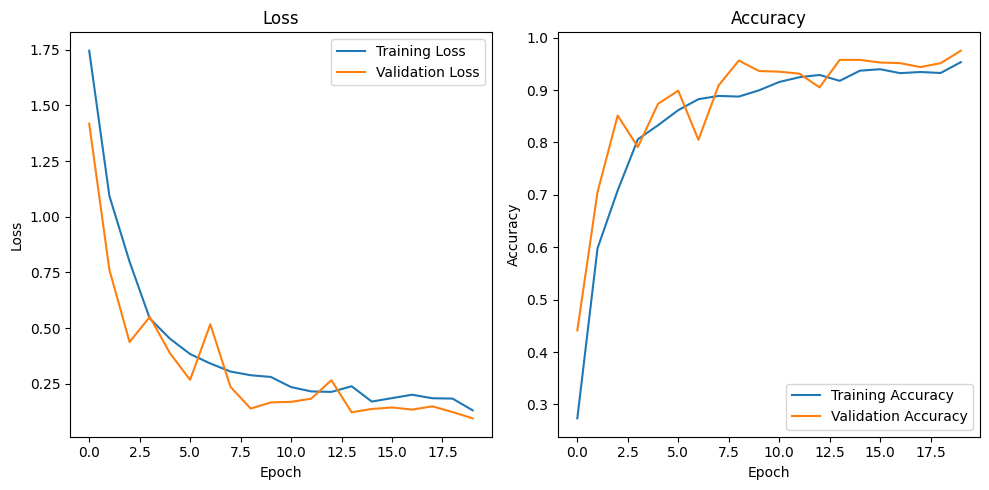

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Evaluate the model on the training data
train_metrics = model.evaluate(train_generator)

# Evaluate the model on the validation data
val_metrics = model.evaluate(val_generator)

# Print the metrics for the training set
print("Metrics for Training Set:")
print(f"Loss: {train_metrics[0]}")
print(f"Accuracy: {train_metrics[1]}")

# Print the metrics for the validation set
print("\nMetrics for Validation Set:")
print(f"Loss: {val_metrics[0]}")
print(f"Accuracy: {val_metrics[1]}")

# Create a table of metrics
metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation'],
    'Loss': [train_metrics[0], val_metrics[0]],
    'Accuracy': [train_metrics[1], val_metrics[1]]
})

print("\nTabular Form of Metrics:")
print(metrics_df)

# Plotting the metrics
plt.figure(figsize=(10, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Saving the trained Model

In [13]:
# Save the trained model
model.save("mango_leaf_disease_model.h5")
model.save('/content/drive/MyDrive/Colab Notebooks/mango_leaf_disease_model.h5')  # HDF5 file

### Testing model predictions

In [14]:
# Load the trained model
loaded_model = keras.models.load_model("mango_leaf_disease_model.h5")

In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the path to the new image you want to test
new_image_path = "/content/drive/MyDrive/Colab Notebooks/Anthracnose/20211008_124249 (Custom).jpg"

# Load and preprocess the new image
img = image.load_img(new_image_path, target_size=image_size)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values

In [16]:
# Make predictions
predictions = loaded_model.predict(img)

# Get class labels and corresponding probabilities
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
predicted_class = class_labels[np.argmax(predictions)]

# Print the result
print(f"The predicted class is: {predicted_class}")
print(f"Prediction probabilities: {predictions[0]}")

1/1 [==============================] - 1s 818ms/step
The predicted class is: Anthracnose
Prediction probabilities: [9.9998724e-01 6.8940892e-08 1.1925905e-06 4.1135741e-07 1.0911452e-05
 3.2993327e-08 1.4514143e-07 5.1724207e-09]
